# Modelos de Mezcla de Funciones Gausianas

### Julián D. Arias Londoño

Profesor Titular  
Departamento de Ingeniería de Sistemas  
Universidad de Antioquia, Medellín, Colombia  
julian.ariasl@udea.edu.co

Hasta el momento hemos visto que existen dos posibles aproximaciones al problema de clasificación:
<li>Encontrar una función que represente la frontera de separación entre dos clases</li>
<li>Separar las muestras por clases y estimar una función de densidad de probabilidad (fdp) por cada una de ellas</li>

Los modelos pertenecientes a la primera aproximación se conocen como <b>Discriminativos</b>, debido a que para el ajuste de la frontera se utilizan las muestras de las dos clases al mismo tiempo y el criterio de ajuste del modelo está directamente relacionado con disminuir el error de clasificación.

Los modelos pertenecientes a la segunda aproximación se conocen como <b>Generativos</b> debido a que los modelos se enfocan principalmente en estimar correctamente la fdp de las muestras de cada clase (por ejemplo maximizar la verosimilitud de los datos y el modelo) y no necesariamente en minimizar el error de clasificación. Una vez se tiene un modelo de densidad de probabilidad éste se puede usar para "generar" nuevas muestras, es decir se puede muestrear la fdp y obtener muestras de la misma distribución, por esa razón recibe el nombre de generativos.

In [6]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import *

Supongamos un problema de clasificación en el cual las muestras se distribuyen de la siguiente manera:

In [3]:
x1 = np.random.rand(2,50)
x2 = np.random.rand(2,50) + 2
x3 = np.random.rand(2,50) + np.tile([[-1],[2]], (1, 50)) #np.tile Es equivalente a repmat en matlab
x4 = np.random.rand(2,50) + np.tile([[3],[1]], (1, 50))
XC1 = np.concatenate((x1,x3),axis=1)
XC2 = np.concatenate((x2,x4),axis=1)
plt.title('Espacio de caracteristicas', fontsize=14)
plt.xlabel('Caracteristica 1')
plt.ylabel('Caracteristica 2')
plt.scatter(XC1[0,:], XC1[1,:])
plt.scatter(XC2[0,:], XC2[1,:],color='red')

Si nuestro deseo es usar un clasificador basado en la fdp de cada clase, y por simplicidad decidimos usar un clasificador por función discriminante Gaussiana, es decir, ajustar una función de densidad Gausiana para cada una de las clases, el resultado obtenido sería el siguiente:

In [4]:
from matplotlib.patches import Ellipse

def plot_ellipse(ax, mu ,sigma):

    vals, vecs = np.linalg.eigh(sigma)
    
    x , y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y,x))
    
    w,h = 4* np.sqrt(vals)
    
    ax.tick_params(axis='both',which='major',labelsize=20)
    ellipse = Ellipse(mu,w,h,theta,color='k')
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

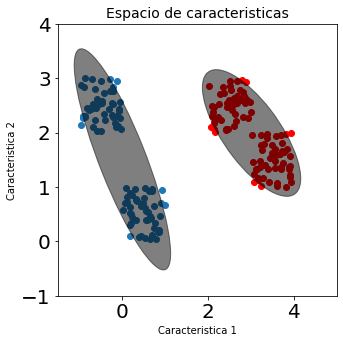

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Espacio de caracteristicas', fontsize=14)
ax.set_xlabel('Caracteristica 1')
ax.set_ylabel('Caracteristica 2')
ax.scatter(XC1[0,:], XC1[1,:])
ax.scatter(XC2[0,:], XC2[1,:],color='red')
ax.set_ylim(-1, 4)
ax.set_xlim(-1.5, 5)
plot_ellipse(ax, np.mean(XC1, axis=1) ,np.cov(XC1))
plot_ellipse(ax, np.mean(XC2, axis=1) ,np.cov(XC2))

En la figura anterior, cada una de las elipses representa la fdp obtenida para cada una de las clases. El centro de la elipse corresponde a su media y la línea corresponde a dos veces la desviación estándar en cada sentido. Como podemos observar en la figura anterior los modelos se ajustan muy mal debido a que las muestras de cada clase no están agrupadas en un solo conglomerado (cluster). En realidad cada clase está a su vez dividida en varios grupos, y lo que necesitamos es un modelo que pueda representar correctamente esos diferentes grupos.

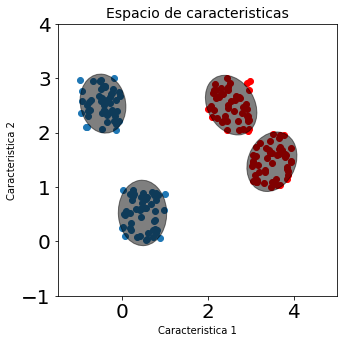

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Espacio de caracteristicas', fontsize=14)
ax.set_xlabel('Caracteristica 1')
ax.set_ylabel('Caracteristica 2')
ax.scatter(XC1[0,:], XC1[1,:])
ax.scatter(XC2[0,:], XC2[1,:],color='red')
ax.set_ylim(-1, 4)
ax.set_xlim(-1.5, 5)
plot_ellipse(ax, np.mean(x1, axis=1) ,np.cov(x1))
plot_ellipse(ax, np.mean(x2, axis=1) ,np.cov(x2))
plot_ellipse(ax, np.mean(x3, axis=1) ,np.cov(x3))
plot_ellipse(ax, np.mean(x4, axis=1) ,np.cov(x4))

Cada conglomerado estaría entonces representado por un vector de medias ${\bf{\mu}}_{ij}$ (clase $i$, conglomerado $j$) y una matriz de covarianza $\Sigma _{ij}$. Sin embargo en este punto surgen varias preguntas que debemos responder:

<li> ¿Qué forma tendría la función de densidad de probabilidad de toda una clase? </li>
<li> ¿En cuántos conglomerados podrían estar agrupadas las muestras? </li>
<li> ¿Cómo determinar cuáles muestras usar para estimar la media y la covarianza del primer conglomerado y cuáles para el segundo? </li>
<li> ¿Cómo se determina el número de conglomerados si no se pueden visualizar las muestras porque el número de características es mayor a 3? </li>

Este tipo de modelos se conocen como <b> Modelos de Mezclas de Funciones Gaussianas</b> (en inglés <b> Gaussian Mixture Models - GMM</b>), y su forma general está dada por la siguiente función:

$$p({\bf{x}}|\Theta_i) = \sum_{j=1}^{M} \omega_{ij} \mathcal{N}({\bf{x}}|\mu_{ij},\Sigma_{ij})$$

In [8]:
def GaussProb(X,medias,covars,pesos):
    M = len(covars)
    N,d = X.shape
    
    Pprob = np.zeros(N).reshape(N,1)
    precision = []
    for i in range(M):
        precision.append(np.linalg.inv(covars[i]))
    
    for j in range(N):
        prob = 0
        for i in range(M):
            tem = (X[j,:]-medias[i])
            tem1 = np.dot(np.dot(tem,precision[i]),tem.T)
            tem2 = 1/((math.pi**(d/2))*(np.linalg.det(covars[i]))**(0.5))
            prob+=pesos[i]*tem2*np.exp(-0.5*tem1)
        Pprob[j] = prob
    return Pprob

donde $M$ es el número de conglomerados en los cuales se van a dividir las muestras, $\omega_{ij}$ son pesos que se le asignan a cada conglomerado, es decir, dan una idea de que tan representativo es el conglomerado dentro de la distribución completa de una clase; deben cumplir la restricción: $\sum_{j=1}^{M} \omega_{ij} = 1$, es decir que la suma de los pesos del modelo GMM para una clase debe ser igual a 1.

El número de conglomerados ($M$) en los cuales se subdivide una clase, es un hiperparámetro del modelo que debe ser ajustado. A partir de las figuras anteriores es fácil determinar que ambas clases están divididas en dos conglomerados, sin embargo, en la gran mayoría de los casos el número de características con las que se cuenta es mucho mayor a 3, razón por la cual no se puede definir el valor de $M$ de manera visual. La forma habitual es utilizar un procedimiento de validación cruzada para hayar el mejor valor de $M$, similar a como debe hacerse para encontrar el mejor valor de $K$ en el modelo de K-vécinos más cercanos.  

El problema de aprendizaje en este caso, corresponde a estimar el conjunto de parámetros $\Theta$ para cada una de las clases, dada un conjunto de muestras de entrenamiento $\mathcal{D} = \left\lbrace  \left( {\bf{x}}_k, y_k \right) \right\rbrace _{k=1} ^{N}$. Del total de muestras de entrenamiento, $N_i$ pertenecen a la clase $i$, es decir $\sum_{i=1}^{\mathcal{C}} N_i = N$, donde $\mathcal{C}$ es el número de clases en el conjunto de muestras de entrenamiento ($y_k$ puede tomar valores $1,2,...,\mathcal{C}$), es decir que el modelo de cada clase se ajusta únicamentente utilizando las $N_i$ muestras pertenecientes a dicha clase.

Como el entrenamiento de un modelo GMM corresponde al ajuste de una fdp, el criterio que nuevamente puede ser de utilidad es el criterio de máxima verosimilitud. Asumiendo entonces que las muestras de entrenamiento de la clase $i$ son i.i.d., podemos expresar el problema de aprendizaje como:

$$\mathop {\max }\limits_\Theta  \log \prod\limits_{k = 1}^{N_i} {p\left( {{\bf{x}}_k |\Theta_i } \right)}$$

reemplazando la forma general del modelo GMM para la clase $i$:

$$ = \mathop {\max }\limits_\Theta  \log \prod\limits_{k = 1}^{N_i} {\sum\limits_{j = 1}^M {w_{ij}{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} }$$

$$= \mathop {\max }\limits_\Theta  \sum\limits_{k = 1}^{N_i} \log {\sum\limits_{j = 1}^M {w_{ij}
{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} }$$

Para encontrar los parámetros que maximizan la función de verosimilitud debemos derivar con respecto a cada uno e igualar a cero. Derivando con respecto a $\mu_{il}$ tenemos:

$$ 0 = - \sum_{k=1}^{N_i} \frac{{w_{il}}\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})} \Sigma _{il}({\bf{x}}_k- \mu _{il})$$

Si observamos con detenimiento el término

$$\gamma_{kl} = \frac{{w_{il}}\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}$$

Mide la probabilidad de que la muestra ${\bf{x}}_k$ sea generada por el conglomerado $l$ dentro de la clase. A $\gamma _{kl}$ también se le conoce como la responsabilidad de la componente $l$ en la "explicación" de la observación de la muestra ${\bf{x}}_k$. 

Reordenando la derivada de la función de verosimilitud que obtuvimos anteriormente, se obtiene:


$$ \hat \mu _{il}  = \frac{1}{n_l} \sum_{k=1}^{N_i} \gamma _{kl} {\bf{x}}_k \;\;\;(*)$$

donde $n_l = \sum_{k=1}^{N_i} \gamma _{kl}$

Teniendo en cuenta que $\gamma _{kl}$ me da una idea del "peso" que tiene la componente $l$ del modelo para generar la muestra $k$, $n_l$ puede entenderse como el peso total de la componente $l$ en el modelo (es una suma para todas las muestras de entrenamiento), o el número total de puntos asignados al conglomerado $l$.

De manera similar se puede derivar con respecto a $\Sigma_{il}$ y obtener:

$$ \hat \Sigma_{il} = \frac{1}{n_l} \sum_{k=1}^{N_i} \gamma _{kl}({\bf{x}}_k - \mu _{il}) ({\bf{x}}_k - \mu _{il})^{T} \;\;\; (* *)$$

que es equivalente a la forma de estimación de la matriz de covarianza en el caso de una sola componente, pero sopesando cada muestra con respecto a la responsabilidad del conglomerado bajo análisis.

Finalmente para la estimación de $w_{ij}$ se hace de manera similar a los dos casos anteriores, pero teniendo en cuenta que los pesos $w$ deben cumplir la restricción estocástica. La función a maximizar en este caso sería:

$$\mathop {\max }\limits_\Theta  \sum\limits_{k = 1}^{N_i} \log {\sum\limits_{j = 1}^M {w_{ij}
{\mathcal N}\left( {{\bf{x}}_k|\mu _{ij} ,\Sigma _{ij} } \right)} } + \lambda \left(\sum _{j=1}^{M} w _{ij} - 1\right)$$

donde $\lambda$ es un multiplicador de Lagrange. Derivando e igualando a cero se obtiene:

$$ 0 = \sum_{k=1}^{N_i} \frac{\mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}  + \lambda$$

Para poder encontrar el valor de $\lambda$ se puede multiplicar a ambos lados de la ecuación anterior por $w_{il}$ 

$$w_{il}\lambda = -\sum_{k=1}^{N_i} \frac{w_{il} \mathcal{N}({\bf{x}}_k|\mu _{il} ,\Sigma _{il})}{\sum _{j} w _{ij} \mathcal{N}({\bf{x}}_k|\mu _{ij} ,\Sigma _{ij})}$$

sumando a ambos lados con respecto a $l$, fácilmente obtendremos que el valor de $\lambda = -N_i$. Por consiguiente reemplazando el valor de $\lambda$ en la ecuación anterior obtendremos:

$$\hat w_{il} = \frac{n_l}{n_i} \;\; (** *) $$

Es importante resaltar que las ecuaciones marcadas con $(*)$ no constituyen una forma cerrada para obtener los valores de los parámetros del modelo, porque todas ellas dependen del valor de $\gamma_{kl}$ que a su vez depende, de una manera compleja, del valor de cada uno de los parámetros. Sin embargo, el resultado proporciona un esquema iterativo simple para encontrar una solución al problema de máxima verosimilitud. El algoritmo que implementa esta solución es conocido como el <b>Algoritmo de Esperanza y Maximización (EM) </b>. Los pasos del algoritmo son: 

<li> Dar un valor inicial a cada uno de los parámetros del modelo </li>
<li> Paso E: Calcular el valor de $\gamma_{kl}$, note que $\gamma$ es en realidad una matriz que contiene un número de filas igual al número de muestras $N_i$ y un número de columnas igual al número de conglomerados $M$. </li>
<li> Paso M: Utilizar el valor de $\gamma$ para encontrar unos nuevos valores de los parámetros del modelo usando las ecuaciones $(*)$. </li>
<li> Repetir consecutivamente los pasos E y M hasta alcanzar convergencia. </li>

El algoritmo EM no garantiza la convergencia a un máximo global, pero si garantiza que en cada iteración (Repetición de los pasos E y M), la verosimilitud del modelo crece o permanece igual, pero no decrece.

Veamos un ejemplo. A continuación se van a generar una serie de valores aletorios unidimensionales y graficaremos el histograma para darnos una idea visual de la forma que tiene la distribución de probabilidad del conjunto de datos:

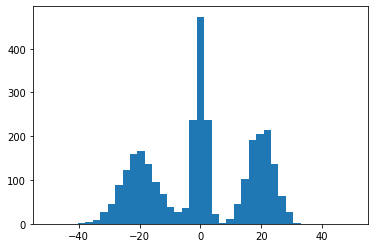

In [9]:
from time import sleep
from numpy import *
from matplotlib.pylab import *

x1 = np.random.normal(0, 2, 1000)
x2 = np.random.normal(20, 4, 1000)
x3 = np.random.normal(-20, 6, 1000)
X = np.concatenate((x1,x2,x3),axis=0)
Y = np.array(X)[np.newaxis]
Y = Y.T
hist(X,41, (-50,50))
show()

Aplicamos el algoritmo EM al conjunto de datos anteriores y veremos el resultado del algoritmo para diferentes iteraciones.

<IPython.core.display.Javascript object>


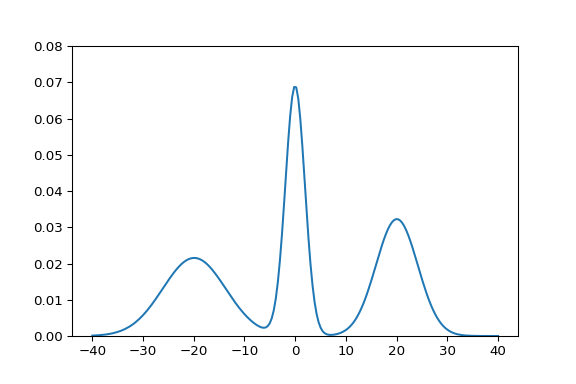

/home/julian/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/home/julian/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/home/julian/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/home/julian/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/home/julian/anacond

In [14]:
%matplotlib notebook
import time
from sklearn.mixture import GaussianMixture
xplt = np.linspace(-40, 40, 200)
x1plt = np.array(xplt).reshape(200,1)
fig, ax = plt.subplots(1,1)
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=1, verbose=0, verbose_interval=10, means_init=np.array([0,4,10]).reshape(3,1))
gmm.fit(Y)
logprob = np.exp(gmm.score_samples(x1plt))
line1, = ax.plot(xplt,logprob)
ax.set_ylim(0,0.08)
for i in [1,3,7,10,20,50,200,500]:
    gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=i, verbose=0, verbose_interval=10, means_init=np.array([0,4,10]).reshape(3,1))
    gmm.fit(Y)
    logprob = np.exp(gmm.score_samples(x1plt))
    line1.set_ydata(logprob)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(.300)

In [15]:
gmm.means_

array([[-1.99064136e+01],
       [-1.38157682e-02],
       [ 2.00397371e+01]])

In [19]:
gmm.covariances_

array([[[ 4.12867708]],

       [[35.54879688]],

       [[15.76805301]]])

En el próximo ejemplo se generarán una serie de muestras en dos dimensiones, a partir de un modelo GMM para el cual los valores de los parámetros se han ajustado de manera arbitraria. Posteriormente se usael algoritmo EM para a partir del conjunto de puntos generados, estima los valores de los parámetros del modelo. Al final podremos comparar que tanto se asemejan los parámetros encontrados por el algoritmo con respecto a los parámetros reales.

Initialization 0
  Iteration 1	 time lapse 0.00364s	 ll change inf
  Iteration 2	 time lapse 0.00070s	 ll change 0.05071
  Iteration 3	 time lapse 0.00062s	 ll change 0.01898
  Iteration 4	 time lapse 0.00061s	 ll change 0.00465
  Iteration 5	 time lapse 0.00061s	 ll change 0.00077
Initialization converged: True	 time lapse 0.00621s	 ll -3.53079


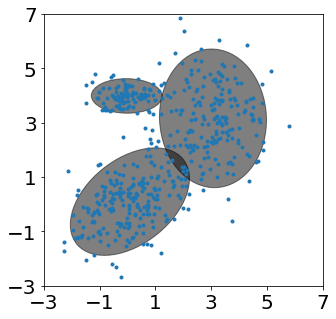

In [21]:
%matplotlib inline
mc = [0.4, 0.4, 0.2] # Mixing coefficients
centroids = [ array([0,0]), array([3,3]), array([0,4]) ]
ccov = [ array([[1,0.4],[0.4,1]]), diag((1,2)), diag((0.4,0.1)) ]

# Generate samples from the gaussian mixture model
x1 = np.random.multivariate_normal(centroids[0], ccov[0], 200)
x2 = np.random.multivariate_normal(centroids[1], ccov[1], 200)
x3 = np.random.multivariate_normal(centroids[2], ccov[2], 100)
X = np.concatenate((x1,x2,x3),axis=0)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(X[:,0], X[:,1], '.')
n_components = 3
#Expectation-Maximization of Mixture of Gaussians
gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=100, verbose=2, verbose_interval=1)
gmm.fit(X)

for i in range(n_components):
    plot_ellipse(ax,gmm.means_[i,:],gmm.covariances_[i,:,:].reshape(2,2))
ax.set_xlim(-3, 7)
ax.set_ylim(-3, 7)
ax.set_xticks(np.arange(-3,8,2)) 
ax.set_yticks(np.arange(-3,8,2)) 

Comparemos los pesos $w$ puestos de manera arbitraria con los pesos hayados por el algoritmo 

In [22]:
print(gmm.weights_)

[0.42674801 0.37234354 0.20090845]


Los centros o medias hayados por el algoritmo

In [23]:
print(gmm.means_)

[[ 0.08966451  0.09753086]
 [ 3.06738309  3.16156099]
 [-0.02314233  3.98580026]]


Y las matrices de covarianza hayadas por el algoritmo

In [31]:
print((gmm.covariances_))

[[[ 1.22314622  0.63396094]
  [ 0.63396094  1.25442089]]

 [[ 0.51712065 -0.00676464]
  [-0.00676464  0.15583978]]

 [[ 0.73013902 -0.04018607]
  [-0.04018607  1.8775274 ]]]


Covarianza diagonal

Initialization 0
  Iteration 1	 time lapse 0.00361s	 ll change inf
  Iteration 2	 time lapse 0.00049s	 ll change 0.04565
  Iteration 3	 time lapse 0.00041s	 ll change 0.02160
  Iteration 4	 time lapse 0.00041s	 ll change 0.00602
  Iteration 5	 time lapse 0.00041s	 ll change 0.00145
  Iteration 6	 time lapse 0.00041s	 ll change 0.00064
Initialization converged: True	 time lapse 0.00577s	 ll -3.56013


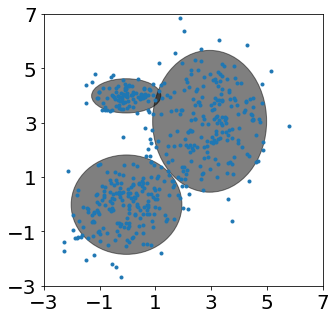

In [24]:
#Expectation-Maximization of Mixture of Gaussians
gmm = GaussianMixture(n_components=3, covariance_type='diag', max_iter=100, verbose=2, verbose_interval=1)
gmm.fit(X)
fig, ax = plt.subplots(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(X[:,0], X[:,1], '.')

for i in range(3):
    plot_ellipse(ax,gmm.means_[i,:],np.diag(gmm.covariances_[i,:]).reshape(2,2))
ax.set_xlim(-3, 7)
ax.set_ylim(-3, 7)
ax.set_xticks(np.arange(-3,8,2)) 
ax.set_yticks(np.arange(-3,8,2)) 

Covarianza esférica

Initialization 0
  Iteration 1	 time lapse 0.00270s	 ll change inf
  Iteration 2	 time lapse 0.00043s	 ll change 0.03748
  Iteration 3	 time lapse 0.00041s	 ll change 0.01621
  Iteration 4	 time lapse 0.00048s	 ll change 0.00577
  Iteration 5	 time lapse 0.00043s	 ll change 0.00217
  Iteration 6	 time lapse 0.00056s	 ll change 0.00092
Initialization converged: True	 time lapse 0.00505s	 ll -3.60150


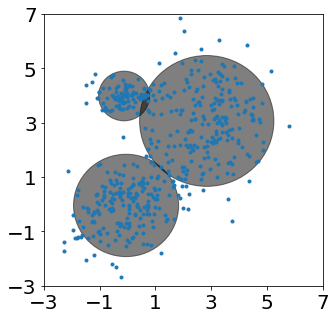

In [25]:
#Expectation-Maximization of Mixture of Gaussians
gmm = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=100, verbose=2, verbose_interval=1)
gmm.fit(X)
fig, ax = plt.subplots(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(X[:,0], X[:,1], '.')

for i in range(3):
    plot_ellipse(ax,gmm.means_[i,:],np.identity(2)* gmm.covariances_[i])
ax.set_xlim(-3, 7)
ax.set_ylim(-3, 7)
ax.set_xticks(np.arange(-3,8,2)) 
ax.set_yticks(np.arange(-3,8,2)) 

-------------------------------------------------------------------------------------------------------------------------------